아래는 ALO 기본 설정 및 라이브러리 설치 코드입니다. library 설치 에러가 발생하면 아래 셀을 재실행 하고, 지속적으로 문제가 있을 시 문의바랍니다

In [1]:
import argparse
import time
import os
import copy

os.chdir(os.path.abspath(os.path.join('./alo')))
from src.alo import ALO
from src.alo import AssetStructure
alo = ALO(); alo.preset(); pipelines = list(alo.asset_source.keys())
from src.external import external_load_data, external_save_artifacts

def run(step, pipeline, asset_structure):
    # 반복되는 작업을 함수로 변환
    asset_config = alo.asset_source[pipeline]
    return alo.process_asset_step(asset_config[step], step, pipeline, asset_structure)

## Train Workflow

In [2]:
# 아래는 Train 시 필요한 라이브러리를 설치하는 코드입니다. library 설치 에러가 발생하면 아래 셀을 재실행 해주세요
external_load_data(pipelines[0], alo.external_path, alo.external_path_permission, alo.control['get_external_data'])
pipeline = pipelines[0]
alo.install_steps(pipeline, alo.control["get_asset_source"])

[2023-11-09 06:47:51,020][PROCESS][INFO]: You did not write any << s3_private_key_file >> in the config yaml file. When you wanna get data from s3 storage, 
                                 you have to write the s3_private_key_file path or set << ACCESS_KEY, SECRET_KEY >> in your os environment. 

[2023-11-09 06:47:51,025][PROCESS][INFO]:  Start loading external data. << /nas001/users/seongwoo.kong/gcr_test_data/sample/ >>  
 << sample >> does not exist in << /home/jovyan/gcr/alo/input/ >>. 
 & << get_external_data >> is set as << once >>. 

[2023-11-09 06:47:51,050][PROCESS][INFO]: Start setting-up << input >> asset @ << assets >> directory.
[2023-11-09 06:47:51,053][PROCESS][INFO]: << input >> asset had already been created at 2023-11-09 06:36:07.478253
[2023-11-09 06:47:51,056][PROCESS][INFO]: Start setting-up << graph >> asset @ << assets >> directory.
[2023-11-09 06:47:51,058][PROCESS][INFO]: << graph >> asset had already been created at 2023-11-09 06:36:09.138270
[2023-11-09 06:4

In [3]:
# 초기 data structure 구성
envs, args, data, config = {}, {}, {}, {}
init_asset_structure = AssetStructure(envs, args, data, config)
# logger init
alo.set_proc_logger()

## Train workflow 
### 0. Input asset 
##### Input asset의 arguments 수정 및 확인
- 필요한경우 input_args의 항목을 ***asset_structure.args[argument명]=value입력*** 을 통해 변경할 수 있습니다.  

In [4]:
# GCR asset 순서에 따라 step 순서를 입력합니다. (input(0) - graph(1) - preprocess(2) - sampling(3) - train(4))
step = 0 
asset_structure = copy.deepcopy(init_asset_structure)
asset_structure.args = alo.get_args(pipeline, step)

# 아래 주석을 풀어 input asset argument를 원하는 값으로 수정합니다. 
# asset_structure.args['x_columns'] = ['']
asset_structure.args

{'input_path': 'sample',
 'x_columns': None,
 'use_all_x': True,
 'y_column': 'is_married',
 'groupkey_columns': None,
 'drop_columns': None,
 'time_column': None,
 'concat_dataframes': None,
 'encoding': None}

##### Input asset 실행 

In [5]:
input_asset_structure=run(step, pipeline, asset_structure)

# input asset의 결과 dataframe은 input_asset_structure.data['dataframe']으로 확인할 수 있습니다. 
input_asset_structure.data['dataframe'].head(10)

[2023-11-09 06:48:02,253][USER][INFO][train_pipeline][input]: >> Load path : ['/home/jovyan/gcr/alo//input/train/sample/']
[2023-11-09 06:48:02,274][USER][INFO][train_pipeline][input]: >> The file for batch data has been loaded. (File name: /home/jovyan/gcr/alo//input/train/sample/customers.csv)
[2023-11-09 06:48:02,277][USER][INFO][train_pipeline][input]: You set the << use_all_x >> as << True >> in the yaml file. So skip checking dataframe columns existence.
[2023-11-09 06:48:02,280][USER][INFO][train_pipeline][input]: ==================== Success loading dataframe ====================
[2023-11-09 06:48:02,283][USER][INFO][train_pipeline][input]: >> Start processing ignore columns & drop columns: ['/home/jovyan/gcr/alo//input/train/sample/customers.csv']
[2023-11-09 06:48:02,286][USER][INFO][train_pipeline][input]: >> You set the << use_all_x >> parameter as << True >> in your config yaml. (So, these x_columns are used: ['name', 'age', 'FLAG_TRAIN_INFERENCE', 'job', 'spent', 'hobbies

[2023-11-09 06:48:02,249][ASSET][INFO][train_pipeline][input]: 

============================= ASSET START =============================
- time (UTC)        : 2023-11-09 06:48:02
- current step      : input
- asset branch.     : tabular_2.0
- alolib ver.       : 2.0
- alo ver.          : release-2.0
- load envs. keys   : dict_keys(['project_home', 'pipeline', 'step', 'num_step', 'artifacts', 'alo_version', 'asset_branch', 'interface_mode', 'load_data', 'load_config', 'save_data', 'save_config', 'log_file_path'])
- load args. keys   : dict_keys(['input_path', 'x_columns', 'use_all_x', 'y_column', 'groupkey_columns', 'drop_columns', 'time_column', 'concat_dataframes', 'encoding'])
- load config. keys : dict_keys(['meta'])
- load data keys    : dict_keys([])


[2023-11-09 06:48:02,287][ASSET][INFO][train_pipeline][input]: 

============================= ASSET FINISH ===========================
- time (UTC)        : 2023-11-09 06:48:02
- current step      : input
- save config. keys : dict

,name,address,gender,age,orders,spent,job,hobbies,is_married,FLAG_TRAIN_INFERENCE
0,Jasmine_Young,TN17745,female,80,0,233.44,Receptionist,Photography,False,TRAIN
1,Jeffery_Robinson,CT69980,male,42,15,264.70,Teacher,Fishing,True,TRAIN
2,Steven_Sullivan,CT13314,male,70,13,339.10,Janitor,Hiking,False,TRAIN
3,Jay_Williams,TN68283,male,27,7,70.61,Waitress,Playing musical instruments,False,TRAIN
4,Benjamin_Beck,AE11377,male,21,9,748.94,Farmer,Playing sports,True,TRAIN
5,Gregory_Gomez,FM04887,male,75,10,937.97,Unkown,Running,False,TRAIN
6,Mary_Harris,KS55063,female,60,12,60.97,Librarian,Reading,True,TRAIN
7,Jimmy_Smith,AL47190,male,72,5,468.64,Waitress,Sewing,False,TRAIN
8,Kenneth_Rubio,RI07301,male,74,15,482.72,Polic,Dancing,True,TRAIN
9,Jordan_Simmons,AA06497,female,41,1,156.16,Cashier,Baking,False,TRAIN


</br>

### 1. Graph asset 
##### Graph asset의 args수정 및 확인
- 필요한경우 graph_args의 항목을 ***asset_structure.args[argument명]=value입력*** 을 통해 변경할 수 있습니다.  

In [6]:
# GCR asset 순서에 따라 step 순서를 입력합니다. (input(0) - graph(1) - preprocess(2) - sampling(3) - train(4))
step = 1 
asset_structure = copy.deepcopy(input_asset_structure)
asset_structure.args = alo.get_args(pipeline, step)

# 아래 주석을 풀어 graph asset argument를 원하는 값으로 수정합니다. 
#asset_structure.args['dimension'] = 128
asset_structure.args

{'graph_type': None,
 'center_node_column': 'name',
 'embedding_column': 'name',
 'train_inference_column': 'FLAG_TRAIN_INFERENCE',
 'drop_columns': [],
 'dimension': 64,
 'num_epochs': 1,
 'workers': None,
 'num_partitions': None,
 'extra_columns_for_ml': [],
 'custom_connection': []}

##### Graph asset 실행 

In [7]:
# asset 실행
graph_asset_structure=run(step, pipeline, asset_structure)

# graph asset의 결과 dataframe은 graph_asset_structure.data['dataframe']으로 확인할 수 있습니다. 
graph_asset_structure.data['dataframe'].head(10)

[2023-11-09 06:48:05,495][ASSET][INFO][train_pipeline][graph]: Successfully got << output path >> for saving your data into csv or jpg file: 
 /home/jovyan/gcr/alo//.train_artifacts/output/graph/ 
 - [NOTE] The names of output file must be fixed as << output.csv, output.jpg >> 
[2023-11-09 06:48:05,498][ASSET][INFO][train_pipeline][graph]: 

============================= ASSET START =============================
- time (UTC)        : 2023-11-09 06:48:05
- current step      : graph
- asset branch.     : release-1.2
- alolib ver.       : 2.0
- alo ver.          : release-2.0
- load envs. keys   : dict_keys(['project_home', 'pipeline', 'step', 'num_step', 'artifacts', 'alo_version', 'asset_branch', 'interface_mode', 'load_data', 'load_config', 'save_data', 'save_config', 'log_file_path', 'prev_step'])
- load args. keys   : dict_keys(['graph_type', 'center_node_column', 'embedding_column', 'train_inference_column', 'drop_columns', 'dimension', 'num_epochs', 'workers', 'num_partitions', 'ex

/home/jovyan/conda/envs/gcr/lib/python3.10/site-packages/torchbiggraph/util.py:222: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = tensor.storage_type()._new_shared(size.numel())
/home/jovyan/conda/envs/gcr/lib/python3.10/site-packages/torch/storage.py:959: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if self.device.type not in ['cpu', 'cuda']:
/home/jovyan/conda/envs/gcr/lib/python3.10/site-packages/torch/storage.py:962: UserWarning: TypedStorage is deprecated. It will be removed in the future and Unty

[Embedding Complete]
[Embeddig result saved at /home/jovyan/gcr/alo//.train_artifacts/output/graph/RESULT]
[2023-11-09 06:48:23,631][ASSET][INFO][train_pipeline][graph]: Successfully got model path for saving or loading your AI model: 
 /home/jovyan/gcr/alo//.train_artifacts/models/graph/
In __del__: pbg deleted
[2023-11-09 06:48:23,681][ASSET][INFO][train_pipeline][graph]: 

============================= ASSET FINISH ===========================
- time (UTC)        : 2023-11-09 06:48:23
- current step      : graph
- save config. keys : dict_keys(['meta', 'data_source_type', 'time_format', 'time_column', 'x_columns', 'input_path', 'group_cnt', 'group_keys', 'y_column', 'input_asset_df_path', 'ignore_columns'])
- save data keys    : dict_keys(['dataframe'])


[2023-11-09 06:48:23,683][PROCESS][INFO]: ==================== Finish pipeline: train_pipeline / step: graph


,name,is_married,EMB_00,EMB_01,EMB_02,EMB_03,EMB_04,EMB_05,EMB_06,EMB_07,...,EMB_54,EMB_55,EMB_56,EMB_57,EMB_58,EMB_59,EMB_60,EMB_61,EMB_62,EMB_63
0,Jasmine_Young,False,0.004884,0.012486,-0.006015,-0.002386,0.011126,-0.008311,0.004959,-0.006470,...,0.009567,0.002214,-0.017530,0.010955,-0.009202,0.002822,-0.011175,-0.015945,-0.005596,0.019304
1,Jeffery_Robinson,True,-0.004965,0.002876,0.008636,-0.010439,0.023527,-0.000226,-0.000218,0.007283,...,-0.001800,-0.004214,-0.002111,-0.006512,0.012473,0.000300,0.015984,0.003432,0.017025,-0.015097
2,Steven_Sullivan,False,-0.007307,-0.001668,0.002815,-0.014262,-0.004650,0.007345,-0.003880,-0.013454,...,0.005106,-0.012092,0.011724,-0.003504,0.002250,-0.021452,0.004200,0.000389,-0.016730,-0.003460
3,Jay_Williams,False,-0.004796,-0.011855,-0.000744,-0.028423,-0.003113,-0.000233,0.004138,-0.000301,...,0.002899,-0.003301,0.007938,0.016012,0.001566,0.002212,0.021466,0.000897,0.017054,0.013091
4,Benjamin_Beck,True,0.008599,0.006184,-0.008778,0.013065,-0.001219,0.003489,-0.002191,0.004630,...,-0.019881,0.011763,0.002243,0.000482,0.008695,0.006855,-0.008508,-0.016589,0.000847,-0.003252
5,Gregory_Gomez,False,0.012754,-0.018615,0.010239,0.001928,-0.000405,-0.003414,0.008341,0.007998,...,0.002808,-0.004254,0.014648,-0.011084,-0.013841,0.000395,0.008417,0.005887,0.011425,-0.015615
6,Mary_Harris,True,-0.016583,-0.007072,0.011364,-0.000602,0.011575,-0.004723,-0.001661,-0.001516,...,-0.004399,0.004914,-0.020739,-0.009642,-0.006034,0.001584,-0.001273,0.003149,-0.009247,-0.009686
7,Jimmy_Smith,False,-0.002064,-0.012578,-0.003306,-0.023773,-0.003994,0.005666,-0.001919,-0.003972,...,0.001486,0.004762,0.007958,0.028603,0.004694,-0.002030,0.009108,0.005748,0.025328,0.014571
8,Kenneth_Rubio,True,0.004767,-0.001059,0.009404,0.004373,0.014389,0.011747,0.014582,-0.001605,...,0.007579,-0.002478,0.005899,-0.006245,-0.014657,0.011261,-0.008563,-0.013228,-0.003193,0.009449
9,Jordan_Simmons,False,0.012619,-0.007292,-0.009820,0.000620,-0.005888,-0.017760,-0.003946,0.009210,...,-0.002693,0.002364,0.010497,0.000895,-0.015153,-0.003669,0.009446,0.002774,0.004930,0.012031


</br>

### 2. Preprocess asset 
##### Preprocess asset의 args수정 및 확인
- 필요한경우 preprocess_args의 항목을 ***asset_structure.args[argument명]=value입력*** 을 통해 변경할 수 있습니다.  

In [8]:
# GCR asset 순서에 따라 step 순서를 입력합니다. (input(0) - graph(1) - preprocess(2) - sampling(3) - train(4))
step = 2 
asset_structure = copy.deepcopy(graph_asset_structure)
asset_structure.args = alo.get_args(pipeline, step)

# 아래 주석을 풀어 preprocess asset argument를 원하는 값으로 수정합니다. 
# asset_structure.args['handling_missing'] = dropna
asset_structure.args

{'handling_missing': 'interpolation',
 'handling_encoding_y_column': 'is_married',
 'handling_encoding_y': 'label',
 'handling_scaling_x': 'none',
 'load_train_preprocess': False}

##### Preprocess asset 실행 

In [9]:
# asset 실행
preprocess_asset_structure=run(step, pipeline, asset_structure)

# preprocess asset의 결과 dataframe은 preprocess_asset_structure.data['dataframe']으로 확인할 수 있습니다.  
preprocess_asset_structure.data['dataframe'].head(10)

[2023-11-09 06:48:26,059][ASSET][INFO][train_pipeline][preprocess]: Successfully got model path for saving or loading your AI model: 
 /home/jovyan/gcr/alo//.train_artifacts/models/preprocess/
[2023-11-09 06:48:26,061][ASSET][INFO][train_pipeline][preprocess]: 

============================= ASSET START =============================
- time (UTC)        : 2023-11-09 06:48:26
- current step      : preprocess
- asset branch.     : release-1.2
- alolib ver.       : 2.0
- alo ver.          : release-2.0
- load envs. keys   : dict_keys(['project_home', 'pipeline', 'step', 'num_step', 'artifacts', 'alo_version', 'asset_branch', 'interface_mode', 'load_data', 'load_config', 'save_data', 'save_config', 'log_file_path', 'prev_step'])
- load args. keys   : dict_keys(['handling_missing', 'handling_encoding_y_column', 'handling_encoding_y', 'handling_scaling_x', 'load_train_preprocess'])
- load config. keys : dict_keys(['meta', 'data_source_type', 'time_format', 'time_column', 'x_columns', 'input_p

,EMB_00,EMB_01,EMB_02,EMB_03,EMB_04,EMB_05,EMB_06,EMB_07,EMB_08,EMB_09,...,EMB_55_nan,EMB_56_nan,EMB_57_nan,EMB_58_nan,EMB_59_nan,EMB_60_nan,EMB_61_nan,EMB_62_nan,EMB_63_nan,is_married_encoded_nan
0,0.004884,0.012486,-0.006015,-0.002386,0.011126,-0.008311,0.004959,-0.006470,-0.012019,-0.014076,...,0.002214,-0.017530,0.010955,-0.009202,0.002822,-0.011175,-0.015945,-0.005596,0.019304,0
1,-0.004965,0.002876,0.008636,-0.010439,0.023527,-0.000226,-0.000218,0.007283,-0.001113,-0.007204,...,-0.004214,-0.002111,-0.006512,0.012473,0.000300,0.015984,0.003432,0.017025,-0.015097,1
2,-0.007307,-0.001668,0.002815,-0.014262,-0.004650,0.007345,-0.003880,-0.013454,0.005971,0.014378,...,-0.012092,0.011724,-0.003504,0.002250,-0.021452,0.004200,0.000389,-0.016730,-0.003460,0
3,-0.004796,-0.011855,-0.000744,-0.028423,-0.003113,-0.000233,0.004138,-0.000301,0.000790,0.010540,...,-0.003301,0.007938,0.016012,0.001566,0.002212,0.021466,0.000897,0.017054,0.013091,0
4,0.008599,0.006184,-0.008778,0.013065,-0.001219,0.003489,-0.002191,0.004630,-0.007333,-0.009585,...,0.011763,0.002243,0.000482,0.008695,0.006855,-0.008508,-0.016589,0.000847,-0.003252,1
5,0.012754,-0.018615,0.010239,0.001928,-0.000405,-0.003414,0.008341,0.007998,-0.013744,-0.005918,...,-0.004254,0.014648,-0.011084,-0.013841,0.000395,0.008417,0.005887,0.011425,-0.015615,0
6,-0.016583,-0.007072,0.011364,-0.000602,0.011575,-0.004723,-0.001661,-0.001516,0.012096,-0.006577,...,0.004914,-0.020739,-0.009642,-0.006034,0.001584,-0.001273,0.003149,-0.009247,-0.009686,1
7,-0.002064,-0.012578,-0.003306,-0.023773,-0.003994,0.005666,-0.001919,-0.003972,0.004233,0.014876,...,0.004762,0.007958,0.028603,0.004694,-0.002030,0.009108,0.005748,0.025328,0.014571,0
8,0.004767,-0.001059,0.009404,0.004373,0.014389,0.011747,0.014582,-0.001605,0.024003,-0.008056,...,-0.002478,0.005899,-0.006245,-0.014657,0.011261,-0.008563,-0.013228,-0.003193,0.009449,1
9,0.012619,-0.007292,-0.009820,0.000620,-0.005888,-0.017760,-0.003946,0.009210,0.000535,0.015868,...,0.002364,0.010497,0.000895,-0.015153,-0.003669,0.009446,0.002774,0.004930,0.012031,0


</br>

### 3. Sampling asset 
##### Sampling asset의 args수정 및 확인
- 필요한경우 Sampling_args의 항목을 ***asset_structure.args[argument명]=value입력*** 을 통해 변경할 수 있습니다.  

In [10]:
# GCR asset 순서에 따라 step 순서를 입력합니다. (input(0) - graph(1) - preprocess(2) - sampling(3) - train(4))
step = 3 
asset_structure = copy.deepcopy(preprocess_asset_structure)
asset_structure.args = alo.get_args(pipeline, step)

# 아래 주석을 풀어 sampling asset argument를 원하는 값으로 수정합니다. 
# asset_structure.args['sampling_type'] = 'under'
asset_structure.args

{'sampling_type': 'none',
 'sampling_method': 'negative',
 'label_sampling': True,
 'ignore_label_class': None,
 'negative_target_class': None,
 'label_sampling_num_type': None,
 'label_sampling_num': {1: 1, 0: 25},
 'sampling_groupkey_columns': None,
 'sampling_num_type': None,
 'sampling_num': None}

##### Sampling asset 실행 

In [11]:
# asset 실행
sampling_asset_structure=run(step, pipeline, asset_structure)

# sampling asset의 결과 dataframe은 sampling_asset_structure.data['dataframe']으로 확인할 수 있습니다.
sampling_asset_structure.data['dataframe'].head(10)

/home/jovyan/conda/envs/gcr/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2023-11-09 06:48:31,630][ASSET][INFO][train_pipeline][sampling]: 

============================= ASSET START =============================
- time (UTC)        : 2023-11-09 06:48:31
- current step      : sampling
- asset branch.     : release-1.2
- alolib ver.       : 2.0
- alo ver.          : release-2.0
- load envs. keys   : dict_keys(['project_home', 'pipeline', 'step', 'num_step', 'artifacts', 'alo_version', 'asset_branch', 'interface_mode', 'load_data', 'load_config', 'save_data', 'save_config', 'log_file_path', 'prev_step'])
- load args. keys   : dict_keys(['sampling_type', 'sampling_method', 'label_sampling', 'ignore_label_class', 'negative_target_class', 'label_sampling_num_type', 'label_sampling_num', 'sampling_groupkey_columns', 'sampling_num_type', 'sampling_num'])
- load config. keys : dict_keys(['meta', 'data_source_type', 'time_format', 'time_column', 'x_columns', 'input_path', 'group_cnt', 'group_keys', 'y_column', 'input_asset_df_path', 'ignore_columns', 'columns_map', 

,EMB_00,EMB_01,EMB_02,EMB_03,EMB_04,EMB_05,EMB_06,EMB_07,EMB_08,EMB_09,...,EMB_55_nan,EMB_56_nan,EMB_57_nan,EMB_58_nan,EMB_59_nan,EMB_60_nan,EMB_61_nan,EMB_62_nan,EMB_63_nan,is_married_encoded_nan
0,0.004884,0.012486,-0.006015,-0.002386,0.011126,-0.008311,0.004959,-0.006470,-0.012019,-0.014076,...,0.002214,-0.017530,0.010955,-0.009202,0.002822,-0.011175,-0.015945,-0.005596,0.019304,0
1,-0.004965,0.002876,0.008636,-0.010439,0.023527,-0.000226,-0.000218,0.007283,-0.001113,-0.007204,...,-0.004214,-0.002111,-0.006512,0.012473,0.000300,0.015984,0.003432,0.017025,-0.015097,1
2,-0.007307,-0.001668,0.002815,-0.014262,-0.004650,0.007345,-0.003880,-0.013454,0.005971,0.014378,...,-0.012092,0.011724,-0.003504,0.002250,-0.021452,0.004200,0.000389,-0.016730,-0.003460,0
3,-0.004796,-0.011855,-0.000744,-0.028423,-0.003113,-0.000233,0.004138,-0.000301,0.000790,0.010540,...,-0.003301,0.007938,0.016012,0.001566,0.002212,0.021466,0.000897,0.017054,0.013091,0
4,0.008599,0.006184,-0.008778,0.013065,-0.001219,0.003489,-0.002191,0.004630,-0.007333,-0.009585,...,0.011763,0.002243,0.000482,0.008695,0.006855,-0.008508,-0.016589,0.000847,-0.003252,1
5,0.012754,-0.018615,0.010239,0.001928,-0.000405,-0.003414,0.008341,0.007998,-0.013744,-0.005918,...,-0.004254,0.014648,-0.011084,-0.013841,0.000395,0.008417,0.005887,0.011425,-0.015615,0
6,-0.016583,-0.007072,0.011364,-0.000602,0.011575,-0.004723,-0.001661,-0.001516,0.012096,-0.006577,...,0.004914,-0.020739,-0.009642,-0.006034,0.001584,-0.001273,0.003149,-0.009247,-0.009686,1
7,-0.002064,-0.012578,-0.003306,-0.023773,-0.003994,0.005666,-0.001919,-0.003972,0.004233,0.014876,...,0.004762,0.007958,0.028603,0.004694,-0.002030,0.009108,0.005748,0.025328,0.014571,0
8,0.004767,-0.001059,0.009404,0.004373,0.014389,0.011747,0.014582,-0.001605,0.024003,-0.008056,...,-0.002478,0.005899,-0.006245,-0.014657,0.011261,-0.008563,-0.013228,-0.003193,0.009449,1
9,0.012619,-0.007292,-0.009820,0.000620,-0.005888,-0.017760,-0.003946,0.009210,0.000535,0.015868,...,0.002364,0.010497,0.000895,-0.015153,-0.003669,0.009446,0.002774,0.004930,0.012031,0


</br>

### 4. Train asset 
##### Train asset의 args수정 및 확인
- 필요한경우 train_args의 항목을 ***asset_structure.args[argument명]=value입력*** 을 통해 변경할 수 있습니다.  

In [12]:
# GCR asset 순서에 따라 step 순서를 입력합니다. (input(0) - graph(1) - preprocess(2) - sampling(3) - train(4))
step = 4 
asset_structure = copy.deepcopy(sampling_asset_structure)
asset_structure.args = alo.get_args(pipeline, step)

# 아래 주석을 풀어 train asset argument를 원하는 값으로 수정합니다.
# asset_structure.args['num_hpo'] = 1
asset_structure.args

{'model_type': 'classification',
 'data_split_method': 'cross_validate',
 'evaluation_metric': 'accuracy',
 'model_list': ['lgb', 'rf', 'cb'],
 'num_hpo': 3,
 'param_range': {'rf': {'max_depth': 6, 'n_estimators': [300, 500]},
  'gbm': {'max_depth': [5, 7], 'n_estimators': [300, 500]},
  'ngb': {'col_sample': [0.6, 0.8], 'n_estimators': [100, 300]},
  'lgb': {'max_depth': [5, 9], 'n_estimators': [300, 500]},
  'cb': {'max_depth': [5, 9], 'n_estimators': [100, 500]}},
 'shap_ratio': 1}

##### Train asset 실행 

[2023-11-09 06:48:32,635][ASSET][INFO][train_pipeline][train]: Successfully got model path for saving or loading your AI model: 
 /home/jovyan/gcr/alo//.train_artifacts/models/train/
[2023-11-09 06:48:32,639][ASSET][INFO][train_pipeline][train]: Successfully got << output path >> for saving your data into csv or jpg file: 
 /home/jovyan/gcr/alo//.train_artifacts/output/train/ 
 - [NOTE] The names of output file must be fixed as << output.csv, output.jpg >> 
[2023-11-09 06:48:32,642][ASSET][INFO][train_pipeline][train]: 

============================= ASSET START =============================
- time (UTC)        : 2023-11-09 06:48:32
- current step      : train
- asset branch.     : tcr_v1.1.1
- alolib ver.       : 2.0
- alo ver.          : release-2.0
- load envs. keys   : dict_keys(['project_home', 'pipeline', 'step', 'num_step', 'artifacts', 'alo_version', 'asset_branch', 'interface_mode', 'load_data', 'load_config', 'save_data', 'save_config', 'log_file_path', 'prev_step'])
- load a


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[INFO] 0th-fold RandomForestClassifier_set0 모델을 학습합니다.(1/36)
[INFO] 1th-fold RandomForestClassifier_set0 모델을 학습합니다.(2/36)
[INFO] 2th-fold RandomForestClassifier_set0 모델을 학습합니다.(3/36)
[INFO] 3th-fold RandomForestClassifier_set0 모델을 학습합니다.(4/36)
[INFO] 0th-fold RandomForestClassifier_set1 모델을 학습합니다.(5/36)
[INFO] 1th-fold RandomForestClassifier_set1 모델을 학습합니다.(6/36)
[INFO] 2th-fold RandomForestClassifier_set1 모델을 학습합니다.(7/36)
[INFO] 3th-fold RandomForestClassifier_set1 모델을 학습합니다.(8/36)
[INFO] 0th-fold RandomForestClassifier_set2 모델을 학습합니다.(9/36)
[INFO] 1th-fold RandomForestClassifier_set2 모델을 학습합니다.(10/36)
[INFO] 2th-fold RandomForestClassifier_set2 모델을 학습합니다.(11/36)
[INFO] 3th-fold RandomForestClassifier_set2 모델을 학습합니다.(12/36)
[INFO] 0th-fold LGBMClassifier_set0 모델을 학습합니다.(13/36)
[INFO] 1th-fold LGBMClassifier_set0 모델을 학습합니다.(14/36)
[INFO] 2th-fold LGBMClassifier_set0 모델을 학습합니다.(15/36)
[INFO] 3th-fold LGBMClassifier_set0 모델을 학습합니다.(16/36)
[INFO] 0th-fold LGBMClassifier_set1 모델을 학습합니다.(17

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



[INFO] 평가 지표는 ( accuracy ) 를 사용합니다. 
모델 정보 로그를 저장합니다. (저장위치: /home/jovyan/gcr/alo//.train_artifacts/models/train/model_selection.json)

Top 1 model file is saved: /home/jovyan/gcr/alo//.train_artifacts/models/train/best_model_top0.pkl
[Score] accuracy: 0.7100
[Hyper-parameters] n_estimators: 300, n_jobs: 1, random_state: 1234, max_depth: 6, 

Top 2 model file is saved: /home/jovyan/gcr/alo//.train_artifacts/models/train/best_model_top1.pkl
[Score] accuracy: 0.7100
[Hyper-parameters] n_estimators: 400, n_jobs: 1, random_state: 1234, max_depth: 6, 

Top 3 model file is saved: /home/jovyan/gcr/alo//.train_artifacts/models/train/best_model_top2.pkl
[Score] accuracy: 0.7088
[Hyper-parameters] n_estimators: 500, n_jobs: 1, random_state: 1234, max_depth: 6, 

Following model is the best: RandomForestClassifier_set0 / accuracy:0.7100


[INFO] Summary_plot for Train data 를 저장했습니다.

ignore columns와 X로 지정한 데이터 프레임을 합치는 과정중에 에러가 발생했습니다. 확인 부탁드립니다.
[2023-11-09 06:50:11,697][ASSET][INFO][train_pipe

,EMB_00_nan,EMB_01_nan,EMB_02_nan,EMB_03_nan,EMB_04_nan,EMB_05_nan,EMB_06_nan,EMB_07_nan,EMB_08_nan,EMB_09_nan,...,EMB_61_nan_shapley,EMB_62_nan_shapley,EMB_63_nan_shapley,is_married_encoded_nan,pred_is_married_encoded_nan,pred_is_married_encoded_nan_best0,pred_is_married_encoded_nan_best1,pred_is_married_encoded_nan_best2,prob_0,prob_1
0,-0.003037,-0.007141,-0.011213,-0.009984,-0.017912,0.006851,0.010962,-0.003464,0.029793,0.002243,...,-0.000259,0.005541,0.000083,0,0,0,0,0,0.730504,0.269496
1,0.020391,0.012623,0.001739,0.006033,0.011504,-0.000077,-0.004077,-0.012035,-0.006936,-0.007154,...,0.001213,0.001441,0.000762,0,0,0,0,0,0.691984,0.308016
2,-0.008391,0.006389,-0.005018,0.005226,-0.010767,-0.006289,-0.011314,0.005314,0.008374,0.012083,...,0.001760,0.003575,-0.002715,0,0,0,0,0,0.657182,0.342818
3,0.028635,0.005089,0.000495,0.000631,0.018450,0.015206,0.014947,0.007226,-0.000419,-0.004884,...,0.001145,0.003794,-0.000589,0,0,0,0,0,0.537598,0.462402
4,0.015572,-0.006919,-0.000248,0.003251,-0.006207,-0.009328,-0.008082,-0.020240,-0.018865,-0.005995,...,0.001787,0.004394,-0.001818,0,0,0,0,0,0.785848,0.214152
5,0.012488,0.010970,0.011845,-0.003121,0.011537,0.009381,-0.006645,0.013332,0.002917,-0.011121,...,0.001826,-0.016766,-0.005733,1,0,0,0,0,0.690500,0.309500
6,0.015535,0.011653,0.010402,-0.000666,0.003416,-0.006812,-0.009825,0.004909,-0.019783,0.012778,...,-0.000291,-0.001245,0.001790,1,0,0,0,0,0.730946,0.269054
7,0.007649,-0.032243,0.013790,-0.007323,0.007871,0.022194,0.022763,-0.013405,0.011214,0.010168,...,-0.000179,0.001657,-0.005593,1,0,0,0,0,0.681749,0.318251
8,-0.008614,0.021736,-0.014558,0.007941,0.001192,0.009667,-0.006560,0.001623,0.000762,-0.006437,...,0.004410,-0.010453,-0.001430,0,0,0,0,0,0.607465,0.392535
9,-0.005371,0.006275,-0.004048,0.005733,-0.015927,0.010633,-0.006541,0.006884,-0.009816,-0.016539,...,0.001190,0.004244,-0.001100,0,0,0,0,0,0.754843,0.245157


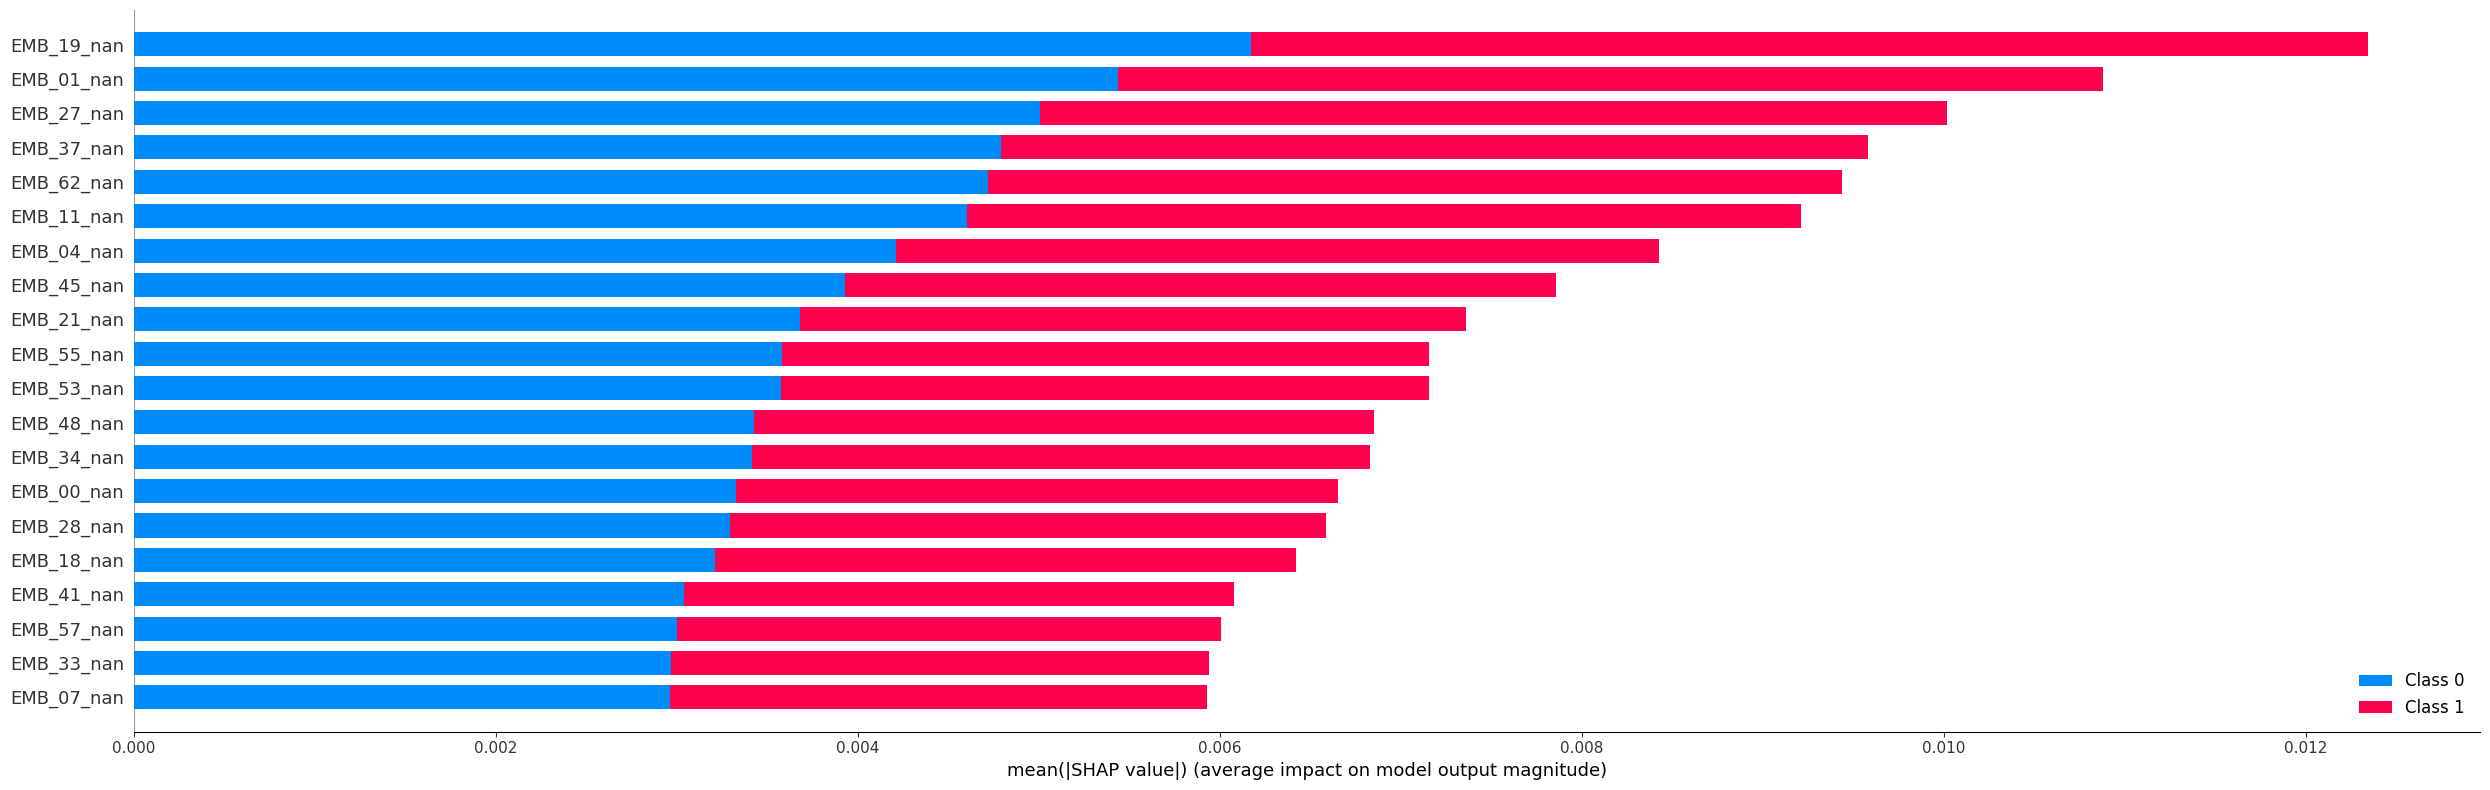

In [13]:
# asset 실행
train_asset_structure=run(step, pipeline, asset_structure)

# train asset의 결과 dataframe은 train_asset_structure.data['dataframe']으로 확인할 수 있습니다.
train_asset_structure.data['dataframe'].head(10)

<br>

## Inference workflow 

In [14]:
# 아래는 Inference 시 필요한 라이브러리를 설치하는 코드입니다. library 설치 에러가 발생하면 아래 셀을 재실행 해주세요
external_load_data(pipelines[1], alo.external_path, alo.external_path_permission, alo.control['get_external_data'])
pipeline = pipelines[1]
alo.install_steps(pipeline, alo.control["get_asset_source"])

[2023-11-09 06:50:11,940][PROCESS][INFO]: You did not write any << s3_private_key_file >> in the config yaml file. When you wanna get data from s3 storage, 
                                 you have to write the s3_private_key_file path or set << ACCESS_KEY, SECRET_KEY >> in your os environment. 

[2023-11-09 06:50:11,943][PROCESS][INFO]: Start setting-up << input >> asset @ << assets >> directory.
[2023-11-09 06:50:11,946][PROCESS][INFO]: Now << local >> asset_source_code mode: <input> asset exists.
[2023-11-09 06:50:11,949][PROCESS][INFO]: Start setting-up << preprocess >> asset @ << assets >> directory.
[2023-11-09 06:50:11,951][PROCESS][INFO]: Now << local >> asset_source_code mode: <preprocess> asset exists.
[2023-11-09 06:50:11,954][PROCESS][INFO]: Start setting-up << inference >> asset @ << assets >> directory.
[2023-11-09 06:50:11,958][PROCESS][INFO]: << inference >> asset had already been created at 2023-11-09 06:38:43.715859
[2023-11-09 06:50:11,961][PROCESS][INFO]: Start set

In [15]:
# 초기 data structure 구성
envs, args, data, config = {}, {}, {}, {}
init_asset_structure = AssetStructure(envs, args, data, config)
# logger init
alo.set_proc_logger()

### 0. Input asset 
##### Input asset의 arguments 수정 및 확인
- 필요한경우 input_args의 항목을 ***asset_structure.args[argument명]=value입력*** 을 통해 변경할 수 있습니다.  

In [16]:
# GCR asset 순서에 따라 step 순서를 입력합니다. (input(0) - preprocess(2) - inference(3) - result(4))
step = 0 
asset_structure = copy.deepcopy(init_asset_structure)
asset_structure.args = alo.get_args(pipeline, step)

# 아래 주석을 풀어 input asset argument를 원하는 값으로 수정합니다.
# asset_structure.args['x_columns'] = ['']
asset_structure.args

{'input_path': 'inference',
 'x_columns': None,
 'use_all_x': True,
 'y_column': None,
 'groupkey_columns': None,
 'drop_columns': None,
 'time_column': None,
 'concat_dataframes': None,
 'encoding': None}

##### Input asset 실행 

In [17]:
# asset 실행
input_asset_structure=run(step, pipeline, asset_structure)

# input asset의 결과 dataframe은 input_asset_structure.data['dataframe']으로 확인할 수 있습니다.
input_asset_structure.data['dataframe'].head(10)

[2023-11-09 06:50:12,014][USER][INFO][inference_pipeline][input]: >> Load path : ['/home/jovyan/gcr/alo//input/inference/inference/']
[2023-11-09 06:50:12,028][USER][INFO][inference_pipeline][input]: >> The file for batch data has been loaded. (File name: /home/jovyan/gcr/alo//input/inference/inference/inference.csv)
[2023-11-09 06:50:12,031][USER][INFO][inference_pipeline][input]: You set the << use_all_x >> as << True >> in the yaml file. So skip checking dataframe columns existence.
[2023-11-09 06:50:12,034][USER][INFO][inference_pipeline][input]: ==================== Success loading dataframe ====================
[2023-11-09 06:50:12,036][USER][INFO][inference_pipeline][input]: >> Start processing ignore columns & drop columns: ['/home/jovyan/gcr/alo//input/inference/inference/inference.csv']
[2023-11-09 06:50:12,040][USER][INFO][inference_pipeline][input]: >> You set the << use_all_x >> parameter as << True >> in your config yaml. (So, these x_columns are used: ['EMB_49', 'EMB_02'

[2023-11-09 06:50:12,010][ASSET][INFO][inference_pipeline][input]: 

============================= ASSET START =============================
- time (UTC)        : 2023-11-09 06:50:12
- current step      : input
- asset branch.     : tabular_2.0
- alolib ver.       : 2.0
- alo ver.          : release-2.0
- load envs. keys   : dict_keys(['project_home', 'pipeline', 'step', 'num_step', 'artifacts', 'alo_version', 'asset_branch', 'interface_mode', 'load_data', 'load_config', 'save_data', 'save_config', 'log_file_path'])
- load args. keys   : dict_keys(['input_path', 'x_columns', 'use_all_x', 'y_column', 'groupkey_columns', 'drop_columns', 'time_column', 'concat_dataframes', 'encoding'])
- load config. keys : dict_keys(['meta'])
- load data keys    : dict_keys([])


[2023-11-09 06:50:12,041][ASSET][INFO][inference_pipeline][input]: 

============================= ASSET FINISH ===========================
- time (UTC)        : 2023-11-09 06:50:12
- current step      : input
- save config. key

,EMB_00,EMB_01,EMB_02,EMB_03,EMB_04,EMB_05,EMB_06,EMB_07,EMB_08,EMB_09,...,EMB_54,EMB_55,EMB_56,EMB_57,EMB_58,EMB_59,EMB_60,EMB_61,EMB_62,EMB_63
0,-0.002611,-0.002001,-0.007244,-0.008264,-0.009245,0.004773,-0.004757,-0.009132,-0.003980,-0.003986,...,-0.008983,-0.016771,-0.032969,0.012735,-0.006551,-0.006155,0.003361,0.012964,0.001979,0.004174
1,0.006203,-0.031904,-0.005630,-0.002246,-0.000162,-0.000785,-0.013895,-0.060086,0.012112,0.010161,...,0.022778,-0.007051,0.014345,0.012054,0.025028,0.003834,0.009762,0.003318,0.005872,-0.006457
2,-0.013035,-0.031346,-0.007259,-0.027150,0.013176,0.001905,0.008632,-0.018074,0.011783,0.013075,...,0.010142,-0.019521,-0.003204,-0.009010,-0.009577,0.012087,0.012509,-0.007436,0.033228,0.020525
3,0.011535,0.002678,0.008933,-0.007592,0.013526,0.010309,-0.004640,0.012302,0.000240,-0.008446,...,0.010726,-0.002434,-0.012074,0.027268,-0.002489,0.012693,-0.000898,-0.006660,0.020033,-0.011353
4,-0.000464,-0.001815,0.007813,-0.005883,0.020563,0.008915,0.023891,-0.008433,0.009153,0.001672,...,0.007791,0.004728,-0.009352,-0.004140,-0.017093,-0.012221,-0.006049,-0.004401,0.004302,-0.003082
5,0.017396,0.018430,-0.019600,-0.000973,0.005116,0.015510,-0.021879,0.007576,-0.019197,0.022846,...,0.012552,0.002626,-0.007688,0.005242,-0.007874,-0.013986,0.018652,0.010788,-0.002692,-0.002896
6,-0.002049,-0.003535,0.003486,-0.010233,-0.011990,0.010471,0.010511,0.006122,0.018677,-0.002852,...,0.008647,0.003313,-0.002718,0.027768,0.012286,-0.015003,-0.010612,-0.012544,0.022089,-0.005592
7,-0.003612,-0.013574,-0.000596,0.011884,-0.016282,0.018033,-0.010712,-0.010708,0.008789,0.023245,...,0.005225,0.002043,-0.001595,0.007095,-0.018613,0.012829,0.010274,0.000282,-0.007128,-0.000380
8,0.002887,-0.014903,-0.013136,-0.017121,-0.001242,0.012092,0.026471,-0.005164,0.040155,0.000823,...,-0.009327,0.000451,-0.014485,-0.006645,-0.001124,0.026861,0.007188,0.003539,0.039540,0.024405
9,0.023049,0.001317,-0.014058,-0.018598,0.010358,0.016791,-0.012068,0.025469,0.021957,-0.022532,...,0.006100,-0.000346,-0.009741,0.027545,0.003370,0.023169,0.017635,-0.004659,0.005299,-0.012603


</br>

### 1. Preprocess asset 
##### Preprocess asset의 args수정 및 확인
- 필요한경우 preprocess_args의 항목을 ***asset_structure.args[argument명]=value입력*** 을 통해 변경할 수 있습니다.  

In [18]:
# GCR asset 순서에 따라 step 순서를 입력합니다. (input(0) - preprocess(2) - inference(3) - result(4))
step = 1 
asset_structure = copy.deepcopy(input_asset_structure)
asset_structure.args = alo.get_args(pipeline, step)

# 아래 주석을 풀어 preprocess asset argument를 원하는 값으로 수정합니다.
# asset_structure.args['x_columns'] = ['']
asset_structure.args

{'handling_missing': 'interpolation',
 'handling_encoding_y_column': None,
 'limit_encoding_categories': 30,
 'load_train_preprocess': True}

##### Preprocess asset 실행 

In [19]:
# asset 실행
preprocess_asset_structure=run(step, pipeline, asset_structure)

# preprocess asset의 결과 dataframe은 preprocess_asset_structure.data['dataframe']으로 확인할 수 있습니다.  
preprocess_asset_structure.data['dataframe'].head(10)

[2023-11-09 06:50:12,076][ASSET][INFO][inference_pipeline][preprocess]: Successfully got model path for saving or loading your AI model: 
 /home/jovyan/gcr/alo//.train_artifacts/models/preprocess/
[2023-11-09 06:50:12,078][ASSET][INFO][inference_pipeline][preprocess]: 

============================= ASSET START =============================
- time (UTC)        : 2023-11-09 06:50:12
- current step      : preprocess
- asset branch.     : release-1.2
- alolib ver.       : 2.0
- alo ver.          : release-2.0
- load envs. keys   : dict_keys(['project_home', 'pipeline', 'step', 'num_step', 'artifacts', 'alo_version', 'asset_branch', 'interface_mode', 'load_data', 'load_config', 'save_data', 'save_config', 'log_file_path', 'prev_step'])
- load args. keys   : dict_keys(['handling_missing', 'handling_encoding_y_column', 'limit_encoding_categories', 'load_train_preprocess'])
- load config. keys : dict_keys(['meta', 'data_source_type', 'time_format', 'time_column', 'x_columns', 'input_path', 'g

,EMB_49,EMB_02,EMB_15,EMB_55,EMB_56,EMB_18,EMB_54,EMB_29,EMB_25,EMB_50,...,EMB_45_nan,EMB_01_nan,EMB_27_nan,EMB_41_nan,EMB_03_nan,EMB_08_nan,EMB_59_nan,EMB_32_nan,EMB_47_nan,EMB_33_nan
0,0.010146,-0.007244,-0.001716,-0.016771,-0.032969,-0.005313,-0.008983,0.005070,0.002706,0.005993,...,0.010868,-0.002001,0.004750,-0.006613,-0.008264,-0.003980,-0.006155,0.009096,0.004048,0.015179
1,0.018737,-0.005630,-0.017798,-0.007051,0.014345,0.007672,0.022778,0.014511,-0.004269,-0.028216,...,-0.008147,-0.031904,-0.022476,0.018488,-0.002246,0.012112,0.003834,0.012858,-0.019594,-0.009072
2,0.007747,-0.007259,-0.003907,-0.019521,-0.003204,0.000379,0.010142,0.002430,-0.037842,-0.019766,...,0.002749,-0.031346,-0.004517,0.022099,-0.027150,0.011783,0.012087,0.032098,0.032730,0.004925
3,0.003393,0.008933,0.009891,-0.002434,-0.012074,-0.008998,0.010726,-0.002448,-0.014632,-0.001509,...,-0.003900,0.002678,0.000816,0.000222,-0.007592,0.000240,0.012693,0.013224,0.002934,-0.017633
4,0.010472,0.007813,-0.016032,0.004728,-0.009352,0.003457,0.007791,0.007896,0.012731,0.012376,...,0.000877,-0.001815,0.001254,-0.006750,-0.005883,0.009153,-0.012221,0.018701,0.004062,-0.001523
5,0.011779,-0.019600,-0.021988,0.002626,-0.007688,0.017618,0.012552,-0.003714,-0.044726,0.018596,...,-0.017815,0.018430,-0.035370,0.017522,-0.000973,-0.019197,-0.013986,0.028463,0.009123,0.002543
6,0.015086,0.003486,-0.005621,0.003313,-0.002718,0.006186,0.008647,0.002292,-0.001996,-0.007421,...,-0.020514,-0.003535,0.010746,0.008236,-0.010233,0.018677,-0.015003,0.000845,0.008515,0.010995
7,0.024821,-0.000596,-0.001121,0.002043,-0.001595,0.005227,0.005225,-0.025767,-0.031729,0.001422,...,0.000501,-0.013574,0.005003,0.020067,0.011884,0.008789,0.012829,0.010682,-0.034486,-0.032593
8,0.031485,-0.013136,0.000392,0.000451,-0.014485,0.029922,-0.009327,-0.006452,-0.014477,-0.019159,...,0.003803,-0.014903,-0.014588,0.022280,-0.017121,0.040155,0.026861,-0.000553,-0.030020,-0.012125
9,0.009314,-0.014058,0.018915,-0.000346,-0.009741,-0.019416,0.006100,-0.034596,-0.047293,-0.008733,...,-0.005962,0.001317,0.015445,0.012442,-0.018598,0.021957,0.023169,0.014019,-0.014469,-0.008606


<br>

### 2. Inference asset 
##### Inference asset의 args수정 및 확인
- 필요한경우 inference_args의 항목을 ***asset_structure.args[argument명]=value입력*** 을 통해 변경할 수 있습니다.  

In [20]:
# GCR asset 순서에 따라 step 순서를 입력합니다. (input(0) - preprocess(2) - inference(3) - result(4))
step = 2 
asset_structure = copy.deepcopy(preprocess_asset_structure)
asset_structure.args = alo.get_args(pipeline, step)

# 아래 주석을 풀어 inference asset argument를 원하는 값으로 수정합니다.
# asset_structure.args['x_columns'] = ['']
asset_structure.args

{'model_type': 'classification', 'run_shapley': False}

##### inference asset 실행 

In [21]:
# asset 실행
inference_asset_structure=run(step, pipeline, asset_structure)

# inference asset의 결과 dataframe은 inference_asset_structure.data['dataframe']으로 확인할 수 있습니다.  
inference_asset_structure.data['dataframe'].head(10)


 ################################### inference_init (sec):  0.0001456737518310547 ################################### 

[2023-11-09 06:50:12,120][ASSET][INFO][inference_pipeline][inference]: 

============================= ASSET START =============================
- time (UTC)        : 2023-11-09 06:50:12
- current step      : inference
- asset branch.     : tcr_v1.1.1
- alolib ver.       : 2.0
- alo ver.          : release-2.0
- load envs. keys   : dict_keys(['project_home', 'pipeline', 'step', 'num_step', 'artifacts', 'alo_version', 'asset_branch', 'interface_mode', 'load_data', 'load_config', 'save_data', 'save_config', 'log_file_path', 'prev_step'])
- load args. keys   : dict_keys(['model_type', 'run_shapley'])
- load config. keys : dict_keys(['meta', 'data_source_type', 'time_format', 'time_column', 'x_columns', 'input_path', 'group_cnt', 'group_keys', 'y_column', 'input_asset_df_path', 'ignore_columns', 'columns_map', 'preprocess'])
- load data keys    : dict_keys(['dataframe'])

,EMB_00,EMB_01,EMB_02,EMB_03,EMB_04,EMB_05,EMB_06,EMB_07,EMB_08,EMB_09,...,EMB_55_nan,EMB_56_nan,EMB_57_nan,EMB_58_nan,EMB_59_nan,EMB_60_nan,EMB_61_nan,EMB_62_nan,EMB_63_nan,prediction
0,-0.002611,-0.002001,-0.007244,-0.008264,-0.009245,0.004773,-0.004757,-0.009132,-0.003980,-0.003986,...,-0.016771,-0.032969,0.012735,-0.006551,-0.006155,0.003361,0.012964,0.001979,0.004174,0
1,0.006203,-0.031904,-0.005630,-0.002246,-0.000162,-0.000785,-0.013895,-0.060086,0.012112,0.010161,...,-0.007051,0.014345,0.012054,0.025028,0.003834,0.009762,0.003318,0.005872,-0.006457,0
2,-0.013035,-0.031346,-0.007259,-0.027150,0.013176,0.001905,0.008632,-0.018074,0.011783,0.013075,...,-0.019521,-0.003204,-0.009010,-0.009577,0.012087,0.012509,-0.007436,0.033228,0.020525,0
3,0.011535,0.002678,0.008933,-0.007592,0.013526,0.010309,-0.004640,0.012302,0.000240,-0.008446,...,-0.002434,-0.012074,0.027268,-0.002489,0.012693,-0.000898,-0.006660,0.020033,-0.011353,0
4,-0.000464,-0.001815,0.007813,-0.005883,0.020563,0.008915,0.023891,-0.008433,0.009153,0.001672,...,0.004728,-0.009352,-0.004140,-0.017093,-0.012221,-0.006049,-0.004401,0.004302,-0.003082,0
5,0.017396,0.018430,-0.019600,-0.000973,0.005116,0.015510,-0.021879,0.007576,-0.019197,0.022846,...,0.002626,-0.007688,0.005242,-0.007874,-0.013986,0.018652,0.010788,-0.002692,-0.002896,0
6,-0.002049,-0.003535,0.003486,-0.010233,-0.011990,0.010471,0.010511,0.006122,0.018677,-0.002852,...,0.003313,-0.002718,0.027768,0.012286,-0.015003,-0.010612,-0.012544,0.022089,-0.005592,0
7,-0.003612,-0.013574,-0.000596,0.011884,-0.016282,0.018033,-0.010712,-0.010708,0.008789,0.023245,...,0.002043,-0.001595,0.007095,-0.018613,0.012829,0.010274,0.000282,-0.007128,-0.000380,0
8,0.002887,-0.014903,-0.013136,-0.017121,-0.001242,0.012092,0.026471,-0.005164,0.040155,0.000823,...,0.000451,-0.014485,-0.006645,-0.001124,0.026861,0.007188,0.003539,0.039540,0.024405,0
9,0.023049,0.001317,-0.014058,-0.018598,0.010358,0.016791,-0.012068,0.025469,0.021957,-0.022532,...,-0.000346,-0.009741,0.027545,0.003370,0.023169,0.017635,-0.004659,0.005299,-0.012603,0


In [24]:
inference_asset_structure.data['dataframe'].columns

Index(['EMB_00', 'EMB_01', 'EMB_02', 'EMB_03', 'EMB_04', 'EMB_05', 'EMB_06',
       'EMB_07', 'EMB_08', 'EMB_09',
       ...
       'EMB_55_nan', 'EMB_56_nan', 'EMB_57_nan', 'EMB_58_nan', 'EMB_59_nan',
       'EMB_60_nan', 'EMB_61_nan', 'EMB_62_nan', 'EMB_63_nan', 'prediction'],
      dtype='object', length=129)

<br>

### 3. Result asset 
##### Result asset의 args수정 및 확인
- 필요한경우 Result_args의 항목을 ***asset_structure.args[argument명]=value입력*** 을 통해 변경할 수 있습니다.  

In [22]:
# GCR asset 순서에 따라 step 순서를 입력합니다. (input(0) - preprocess(2) - inference(3) - result(4))
step = 3
asset_structure = copy.deepcopy(inference_asset_structure)
asset_structure.args = alo.get_args(pipeline, step)

# 아래 주석을 풀어 result asset argument를 원하는 값으로 수정합니다.
# asset_structure.args['x_columns'] = ['']
asset_structure.args

{'result_save_name': None}

##### result asset 실행 

In [23]:
# asset 실행
result_asset_structure=run(step, pipeline, asset_structure)

# result asset의 결과 dataframe은 result_asset_structure.data['dataframe']으로 확인할 수 있습니다.
result_asset_structure.data['dataframe'].head(10)

[2023-11-09 06:50:12,335][ASSET][INFO][inference_pipeline][result]: 

============================= ASSET START =============================
- time (UTC)        : 2023-11-09 06:50:12
- current step      : result
- asset branch.     : release-1.2
- alolib ver.       : 2.0
- alo ver.          : release-2.0
- load envs. keys   : dict_keys(['project_home', 'pipeline', 'step', 'num_step', 'artifacts', 'alo_version', 'asset_branch', 'interface_mode', 'load_data', 'load_config', 'save_data', 'save_config', 'log_file_path', 'prev_step'])
- load args. keys   : dict_keys(['result_save_name'])
- load config. keys : dict_keys(['meta', 'data_source_type', 'time_format', 'time_column', 'x_columns', 'input_path', 'group_cnt', 'group_keys', 'y_column', 'input_asset_df_path', 'ignore_columns', 'columns_map', 'preprocess'])
- load data keys    : dict_keys(['dataframe'])


Loading Embeddings
[2023-11-09 06:50:12,339][ASSET][INFO][inference_pipeline][result]: Successfully got model path for saving or loa

,name,is_married,prediction
0,Gregory_Hull,NaN,0
1,Allison_Peterson,NaN,0
2,Daniel_Davies,NaN,0
3,Alison_Fox,NaN,0
4,Daniel_Moore,NaN,0
5,Barbara_Smith,NaN,0
6,Paul_Terry,NaN,0
7,Christina_Salas,NaN,0
8,Jose_Boyd,NaN,0
9,Zachary_Fowler,NaN,0
